In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

molecule = "propane"

topfile = molecule + ".top"

parameter_dir = "../topology_code/"

#####################################################################################
# Creating a dictionary containing the info from the topology file
#####################################################################################
terms = ["[AtomTypes]","[Bonds]","[Angles]","[ImproperDihedrals]","[Dihedrals]","[LJ]","[Charges]"]
with open(parameter_dir+topfile) as file:
    lines = []
    for line in file:
        lines.append(line)
    file.close()

def mkdic(lines,terms):
    #create ampty dictionary, that will be filled with the content from the topology file, but only if the entries of the block exist, e.g. if there ar no improper torsions, there will be no key for these in the dictionary
    dic={}
    #iterate through the whole topology file
    line_nr = -1
    for line in lines:
        line_nr += 1
        # check if we are at the start of a new block, corresponding to a particular term, or the initial block declaring AtomTypes
        if line.startswith("[AtomTypes]"):
            #get number of atoms for the given molecule
            natoms = int(line.split()[1])
        for term in terms:
            #if we are at the descriptor line for a new term, e.g. [LJ] or [Angles]
            if line.startswith(term):
                #retrieve the number of entries for each block (e.g. if there are 18 dihedrals, nlines=18)
                if len(line.split()) != 2: #the blocks in the topology file for LJ and charges don't have the number of lines written next to the descriptor
                    nlines=natoms
                else:
                    nlines=int(line.split()[1]) # for all other blocks, the descriptor line (e.g. [Dihedrals] 18) has the number of lines written nect to it
                # add the entries to the dictionary; ONLY if there are entries; otherwise don't even create a key 
                if nlines != 0:
                    dic[term]=[]
                    for i in range(nlines):
                        #print(lines[line_nr+i+1])
                        dic[term].append(lines[line_nr+i+1].split("\t"))
    return dic

dic=mkdic(lines,terms)

#print(dic)



print("\n-----------------------------------------------------------------------")
print("The created dictionary contains the following content\nwith the number of lines written on the right.")
print("The first line of each block given below as well:\n")
for term in dic:
    #print(term,"\n",dic[term])
    print(term,len(dic[term]))
    print(dic[term][0])
    print(dic[term][1])
    print()
print("-----------------------------------------------------------------------")



-----------------------------------------------------------------------
The created dictionary contains the following content
with the number of lines written on the right.
The first line of each block given below as well:

[AtomTypes] 11
['1', 'C', 'CT', '12.01\n']
['2', 'C', 'CT', '12.01\n']

[Bonds] 10
['1', '2', '0.1526', '259408.0\n']
['2', '3', '0.1526', '259408.0\n']

[Angles] 18
['CT-CT-HC', '2', '1', '4', '109.5', '418.4\n']
['CT-CT-HC', '2', '1', '5', '109.5', '418.4\n']

[Dihedrals] 36
['HC-CT-CT-CT', '4', '1', '2', '3', '9', '0.0', '0.66944', '3\n']
['HC-CT-CT-CT', '5', '1', '2', '3', '9', '0.0', '0.66944', '3\n']

[LJ] 11
['1', '3.39967E-01', '4.5773E-01\n']
['2', '3.39967E-01', '4.5773E-01\n']

[Charges] 11
['1', '-0.19018864940136362\n']
['2', '0.07079249039121673\n']

-----------------------------------------------------------------------


In [2]:
## read in the coordinates:
coordfile = molecule + ".xyz"
with open(parameter_dir+coordfile) as file:
    coordfile_lines = []
    for line in file:
        coordfile_lines.append(line.split("\n")[0])
    file.close()
natoms=int(coordfile_lines[0])


coords = []
for i in range(natoms):
    line = coordfile_lines[i+2].split(" ")
    coordline = []
    for entry in line:
        if entry != "" and entry!=line[0]:
            coordline.append(float(entry))
    coords.append(coordline)
coords=np.asarray(coords)

if (coords.shape[0]!=natoms):
    print("WARNING: sth is wrong with the xyz file")

print(dic["[Bonds]"])

[['1', '2', '0.1526', '259408.0\n'], ['2', '3', '0.1526', '259408.0\n'], ['1', '4', '0.109', '284512.0\n'], ['1', '5', '0.109', '284512.0\n'], ['1', '6', '0.109', '284512.0\n'], ['2', '7', '0.109', '284512.0\n'], ['2', '8', '0.109', '284512.0\n'], ['3', '9', '0.109', '284512.0\n'], ['3', '10', '0.109', '284512.0\n'], ['3', '11', '0.109', '284512.0\n']]


## Some security checks
- check the total charge
- check which terms are included, and how many

In [3]:
# check the total charge
charges = dic["[Charges]"]
total_charge = 0
for line in charges:
    total_charge += float(line[1])
print("The molecule has a total charge of %.6f"%total_charge)

#check which terms are included
print("\nThe following terms will be considered:")
for term in dic:
    print(term,len(dic[term]))

The molecule has a total charge of 0.000000

The following terms will be considered:
[AtomTypes] 11
[Bonds] 10
[Angles] 18
[Dihedrals] 36
[LJ] 11
[Charges] 11


# potential energy
\begin{align}
    U 
    &= 
    \underbrace{\sum_{\text{Bonds}} \frac{k_b}{2} (b-b_0)^2}_{U_{bonds}}
    + \underbrace{\sum_{\text{Angles}} \frac{k_{\theta}}{2}  (\theta-\theta_0)^2}_{U_{angles}}
    + \underbrace{\sum_{\text{torsions}} \frac{V_n}{2} \bigl[1+\cos(n\omega-\gamma)\bigr]}_{U_{dihedrals}}
    \nonumber \\ \quad \quad
    &+ \underbrace{\sum_{i=1}^{N-1}\sum_{j=i+1}^{N} 4\epsilon_{ij} \biggl[\biggl(\frac{\sigma_{ij}}{r_{ij}} \biggr)^{12} - \biggl( \frac{\sigma_{ij}}{r_{ij}}\biggr)^{6} \biggr]}_{U_{LJ}}
    + \underbrace{\sum_{i=1}^{N-1}\sum_{j=i+1}^{N} \frac{q_iq_j}{4\pi \epsilon_0 r_{ij}} }_{U_{Coulomb}}
\end{align}

## bond potential
\begin{align}
U_{bonds}(b) = \frac{1}{2} k_b (b-b_0)^2
\end{align}

In [4]:
U_bonds = []
n_interactions = 0

bonded_atoms = []

def vec_norm(vec):
    norm = 0
    for i in range(len(vec)):
        norm += vec[i]**2
    norm = np.sqrt(norm)
    return norm


print("        bond    (i,j)      b [nm]      b0 [nm]    kb [kJ/(mol*nm^2)]    U_bond [kJ/mol]")
print("=============================================================================================================")
for entryline in range(len(dic["[Bonds]"])):
    n_interactions += 1
    atom1=int(dic["[Bonds]"][entryline][0])-1
    atom2=int(dic["[Bonds]"][entryline][1])-1
    bonded_atoms.append((atom1,atom2))

    
    b0=float(dic["[Bonds]"][entryline][2])
    kb=float(dic["[Bonds]"][entryline][3])

    atom1_name=dic["[AtomTypes]"][atom1][1]
    atom2_name=dic["[AtomTypes]"][atom2][1]
    atoms = atom1_name+"-"+atom2_name
    
    atom1_type=dic["[AtomTypes]"][atom1][2]
    atom2_type=dic["[AtomTypes]"][atom2][2]
    #atoms = atom1_type+"-"+atom2_type
    
    # calculate actual bond length from xyz (note that this is in angstrom)
    bond_vector = coords[atom2] - coords[atom1]
    b=vec_norm(bond_vector)
    #convert to nm
    b=b*0.1
    
    U_bond = 1/2*kb*(b-b0)**2
    U_bonds.append(float(U_bond))
    #print("i = %3i; j = %3i; b = %.4f nm; b0 = %.4f nm; U_bonds = %.4f kJ/mol"%(atom1+1,atom2+1,b,b0,U_bond))
    print("%3i)    %s   %3i %3i      %.4f      %.4f     %.1f              %.4f"%(n_interactions,atoms,atom1+1,atom2+1,b,b0,kb,U_bond))

total_U_bonds = sum(U_bonds)
print("\nTotal: \nU_bonds = %.4f kJ/mol" %total_U_bonds)

        bond    (i,j)      b [nm]      b0 [nm]    kb [kJ/(mol*nm^2)]    U_bond [kJ/mol]
  1)    C-C     1   2      0.1512      0.1526     259408.0              0.2539
  2)    C-C     2   3      0.1503      0.1526     259408.0              0.6775
  3)    C-H     1   4      0.1114      0.1090     284512.0              0.7999
  4)    C-H     1   5      0.1096      0.1090     284512.0              0.0482
  5)    C-H     1   6      0.1116      0.1090     284512.0              0.9860
  6)    C-H     2   7      0.1114      0.1090     284512.0              0.7977
  7)    C-H     2   8      0.1112      0.1090     284512.0              0.6876
  8)    C-H     3   9      0.1099      0.1090     284512.0              0.1131
  9)    C-H     3  10      0.1115      0.1090     284512.0              0.8874
 10)    C-H     3  11      0.1119      0.1090     284512.0              1.2234

Total: 
U_bonds = 6.4747 kJ/mol


## angle potential
\begin{align}
U_{angles} (\theta)= \frac{1}{2} k_{\theta} (\theta-\theta_0)^2
\end{align}

\begin{align}
\vec{a}\cdot\vec{b} = |\vec{a}|\cdot|\vec{b}|\cdot \cos(\theta) \\
\Leftrightarrow \theta = \arccos \biggl(\frac{\vec{a}\cdot\vec{b}}{|\vec{a}|\cdot|\vec{b}|}\biggr) 
\end{align}


In [5]:
U_angles = []
n_interactions = 0
def angle_between(vec1,vec2):
    gamma_rad=np.arccos(np.dot(vec1,vec2)/(vec_norm(vec1)*vec_norm(vec2)))
    gamma_deg=float(gamma_rad)/np.pi*180
    return gamma_deg

print("        angle      (i,j,k)       th [deg]      th0 [deg]     k0 [kcal/(mol*rad^2)]         U_bond [kcal/mol]")
print("=============================================================================================================")
for entryline in range(len(dic["[Angles]"])):
    n_interactions += 1
    atom1=int(dic["[Angles]"][entryline][1])-1
    atom2=int(dic["[Angles]"][entryline][2])-1
    atom3=int(dic["[Angles]"][entryline][3])-1

    atom1_name=dic["[AtomTypes]"][atom1][1]
    atom2_name=dic["[AtomTypes]"][atom2][1]
    atom3_name=dic["[AtomTypes]"][atom3][1]
    atoms = atom1_name+"-"+atom2_name+"-"+atom3_name
    #atoms=dic["[Angles]"][entryline][0]
    
    th0=float(dic["[Angles]"][entryline][4]) 
    k0=float(dic["[Angles]"][entryline][5]) # in kJ/mol/rad^2
    k0=k0/4.18 # in kJ/mol/rad^2
    k0_deg = k0/(180**2)*((np.pi)**2)
    #k0_rad=k0*180**2/((np.pi)**2)
    #k0=k0_rad/1000 #in kJ/mol/rad^2
    #k0=k0/4.18 #in kcal/mol/rad^2
    
    # calculate actual angle from xyz (note that this is in angstrom)
    bond_vector_1 = coords[atom1] - coords[atom2]
    bond_vector_2 = coords[atom3] - coords[atom2]
    
    th=angle_between(bond_vector_1,bond_vector_2)
    
    U_angle = 1/2*k0_deg*(th-th0)**2
    
    U_angles.append(float(U_angle))
    #print("i = %3i; j = %3i; b = %.4f nm; b0 = %.4f nm; U_bonds = %.4f kJ/mol"%(atom1+1,atom2+1,b,b0,U_bond))
    print("%3i)    %s     %2i %2i %2i       %.4f        %.1f         %8.4f                    %10.4f "%(n_interactions,atoms,atom1+1,atom2+1,atom3+1,th,th0,k0,U_angle))

total_U_angles = sum(U_angles)
print("\nTotal: \nU_bonds = %.4f kJ/mol" %total_U_angles)

        angle      (i,j,k)       th [deg]      th0 [deg]     k0 [kcal/(mol*rad^2)]         U_bond [kcal/mol]
  1)    C-C-H      2  1  4       112.0566        109.5         100.0957                        0.0996 
  2)    C-C-H      2  1  5       112.8798        109.5         100.0957                        0.1741 
  3)    C-C-H      2  1  6       109.0051        109.5         100.0957                        0.0037 
  4)    H-C-H      4  1  5       108.8876        109.5          70.0670                        0.0040 
  5)    H-C-H      4  1  6       105.3038        109.5          70.0670                        0.1879 
  6)    H-C-H      5  1  6       108.3717        109.5          70.0670                        0.0136 
  7)    C-C-C      1  2  3       112.5120        109.5          80.0766                        0.1106 
  8)    C-C-H      1  2  7       112.2814        109.5         100.0957                        0.1179 
  9)    C-C-H      1  2  8       112.7988        109.5         100.

# torsional potential
\begin{align}
    U_{dihedrals} (\phi)= 
     \frac{\text{barrierterm}}{\text{div}} \bigl[1-\cos(\text{periodicity} \cdot \phi+ \text{phase})\bigr]
\end{align}

In [6]:
entryline = 0

U_dihedrals = []
n_interactions = 0

print("        dihedral      (i,j,k,l)       phi [deg]      div,  phase,     barrier_term,   periodicity         U_bond [kcal/mol]")
print("=========================================================================================================================")
for entryline in range(len(dic["[Dihedrals]"])):
    n_interactions += 1
    atom1=int(dic["[Dihedrals]"][entryline][1])-1
    atom2=int(dic["[Dihedrals]"][entryline][2])-1
    atom3=int(dic["[Dihedrals]"][entryline][3])-1
    atom4=int(dic["[Dihedrals]"][entryline][4])-1
    
    atom1_name=dic["[AtomTypes]"][atom1][1]
    atom2_name=dic["[AtomTypes]"][atom2][1]
    atom3_name=dic["[AtomTypes]"][atom3][1]
    atom4_name=dic["[AtomTypes]"][atom4][1]
    atoms = atom1_name+"-"+atom2_name+"-"+atom3_name+"-"+atom4_name
    #atoms=dic["[Angles]"][entryline][0]
    
    div=int(dic["[Dihedrals]"][entryline][5])
    phase=float(dic["[Dihedrals]"][entryline][6]) #phase /deg
    barrier_term=float(dic["[Dihedrals]"][entryline][7]) 
    periodicity=int(dic["[Dihedrals]"][entryline][8])
    
    # calculate actual dihedral from xyz (note that this is in angstrom)
    bond_vector_12 = coords[atom1] - coords[atom2]
    bond_vector_23 = coords[atom2] - coords[atom3]
    bond_vector_34 = coords[atom3] - coords[atom4]
    
    #print(bond_vector_12,bond_vector_23,bond_vector_34)
    # the dihedral is the angle between the planes spanned by 12 and 23; and 23 and 34
    # the angle between two planes can be calculated by calculating the angle between the respectiv normal vectors
    # the normal vectors are obtained using the cross product
    n1 = np.cross(bond_vector_12,bond_vector_23)
    n2 = np.cross(bond_vector_23,bond_vector_34)
    
    #print(n1,n2)
    
    phi=angle_between(n1,n2)
    
    U_dihedral = barrier_term/div*(1+np.cos((periodicity*phi-phase)/360*(2*np.pi)))
    
    U_dihedrals.append(float(U_dihedral))
    print("%3i)    %s     %2i %2i %2i %2i       %8.3f       %3.1f %8.3f         %.4f        %.4f           %10.4f "%(n_interactions,atoms,atom1+1,atom2+1,atom3+1,atom4+1,phi, div,phase,barrier_term,periodicity,U_dihedral*100/4.18))

total_U_dihedrals = sum(U_dihedrals)
print("\nTotal: \nU_bonds = %.4f kJ/mol" %total_U_dihedrals)



# GAFF2 hc-c3-c3-hc   1    0.120         0.000           3.000      m1-2021


        dihedral      (i,j,k,l)       phi [deg]      div,  phase,     barrier_term,   periodicity         U_bond [kcal/mol]
  1)    H-C-C-C      4  1  2  3        123.177       9.0    0.000         0.6694        3.0000               3.5344 
  2)    H-C-C-C      5  1  2  3          0.196       9.0    0.000         0.6694        3.0000               3.5589 
  3)    H-C-C-C      6  1  2  3        120.671       9.0    0.000         0.6694        3.0000               3.5579 
  4)    H-C-C-H      4  1  2  7        117.272       9.0    0.000         0.6276        3.0000               3.3195 
  5)    H-C-C-H      5  1  2  7        119.355       9.0    0.000         0.6276        3.0000               3.3356 
  6)    H-C-C-H      6  1  2  7          1.121       9.0    0.000         0.6276        3.0000               3.3337 
  7)    H-C-C-H      4  1  2  8          1.287       9.0    0.000         0.6276        3.0000               3.3327 
  8)    H-C-C-H      5  1  2  8        122.086       9.0 

## improper torsional potential
\begin{align}
    U_{dihedrals} (\phi)= 
     \frac{\text{barrierterm}}{\text{div}} \bigl[1-\cos(\text{periodicity} \cdot \phi+ \text{phase})\bigr]
\end{align}

In [7]:
def plot_U_impdihedral(dic,entryline, printhere=False):
    atoms=dic["[ImproperDihedrals]"][entryline][0]
    div=int(dic["[ImproperDihedrals]"][entryline][5])
    phase=float(dic["[ImproperDihedrals]"][entryline][6]) #phase /deg
    barrier_term=float(dic["[ImproperDihedrals]"][entryline][7]) 
    periodicity=int(dic["[ImproperDihedrals]"][entryline][8])
    
    phi=np.linspace(0,360) # in deg
    
    U_impdihedral = barrier_term/div*(1+np.cos((periodicity*phi-phase)/360*(2*np.pi)))
    
    plt.figure()
    plt.plot(phi,U_impdihedral)
    plt.title("$U_{impdihedral}(φ) = barrierterm/div \cdot[1+cos(nφ-δ)]$\nwith $barrierterm$=%.3f kJ mol$^{-1}$;div=%i $n=%.3f$; $δ$=%.4f deg"%(barrier_term,div,periodicity,phase))
    plt.xlabel("$φ_{%s}$ / deg"%atoms)
    plt.ylabel("$U_{impdihedral}$ / kJ mol$^{-1}$")
    
    plt.xlim([0,360])
    #plt.ylim([0,2e7])
    plt.savefig("%s_U_impdihedral.png"%molecule, dpi=300)
    
    if printhere==False:
        plt.close()
    return



In [8]:
#plot_U_impdihedral(dic,6,printhere=True)

## LJ potential
\begin{align}
U_{LJ}(r_{ij}) = 4\epsilon_{ij} \biggl[\biggl(\frac{\sigma_{ij}}{r_{ij}} \biggr)^{12} - \biggl( \frac{\sigma_{ij}}{r_{ij}}\biggr)^{6} \biggr]
\end{align}

In [9]:
interactions = []
for atom1 in range(0,len(dic["[LJ]"])-1):
    for atom2 in range(atom1+1,len(dic["[LJ]"])):
        if (atom1,atom2) in bonded_atoms:
            print(atom1,atom2)
        else:
            interactions.append((atom1,atom2))
print(interactions)
print(len(interactions))

interaction_types =[]
for pair in interactions:
    interaction_types.append((dic["[AtomTypes]"][pair[0]][1]+"-"+dic["[AtomTypes]"][pair[1]][1]))
print(interaction_types)
nCH,nCC,nHH=0,0,0
for interaction in interaction_types:
    if interaction == ("C-H") or interaction == ("H-C"):
        nCH += 1
    if interaction == ("H-H"):
        nHH += 1
    if interaction == ("C-C"):
        nCC += 1
print(nCH,nHH,nCC)

0 1
0 3
0 4
0 5
1 2
1 6
1 7
2 8
2 9
2 10
[(0, 2), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (1, 3), (1, 4), (1, 5), (1, 8), (1, 9), (1, 10), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 7), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (9, 10)]
45
['C-C', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'C-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H', 'H-H']
16 28 1


## Coulomb potential
\begin{align}
U_{Coulomb}(r_{ij})= \frac{q_iq_j}{4\pi \epsilon_0 r_{ij}} 
\end{align}

In [10]:
def plot_U_Coulomb(dic,entrylines,printhere=False):
    #entrylines=[0,1]
    atom_i = entrylines[0]
    atom_j = entrylines[1]
    
    atom_nr_i=int(dic["[Charges]"][atom_i][0])
    atom_type_i=dic["[AtomTypes]"][atom_nr_i-1][2]
    q_i=float(dic["[Charges]"][atom_i][1]) # in fraction of e
    
    atom_nr_j=int(dic["[Charges]"][atom_j][0])
    atom_type_j=dic["[AtomTypes]"][atom_nr_j-1][2]
    q_j=float(dic["[Charges]"][atom_j][1]) # in fraction of e
    
    print(atom_type_i,q_i)
    print(atom_type_j,q_j)
    eps_0_SI = 8.8541878188e-12 #Si units: C^2/(J*m)
    e_SI = 1.602176634e-19 #SI units: C
    
    eps_0 = eps_0_SI * 10**(-6) # in C^2/(kJ*nm)
    eps_0 = eps_0 / (e_SI)**2 # in e^2/(kJ*nm)
    print(1/(4* np.pi* eps_0))
    
    r_ij=np.linspace(-0.5,10,1001) # in nm
    U_Coulomb = 1/(4* np.pi* eps_0) * q_i*q_j/r_ij
    
    plt.figure()
    plt.plot(r_ij,U_Coulomb)
    plt.title("$U_{Coulomb}(r_{ij}) = 1/(4πε_0) \cdot q_i q_j/r_{ij} $ \n with $q_{i} = %.3f e$ and $q_{j} =%.3f e$ \n"%(q_i,q_j))
    plt.xlabel("$r_{%s}$ / nm"%(atom_type_i+"-"+atom_type_j))
    plt.ylabel("$U_{Coulomb}$ / kJ mol$^{-1}$")

    plt.xlim([0,4])
    plt.savefig("%s_U_Coulomb.png"%molecule, dpi=300)

    if printhere==False:
        plt.close()
    return

CT 0.07079249039121673
HC -0.024958797579555877
2.3070775507783552e-22


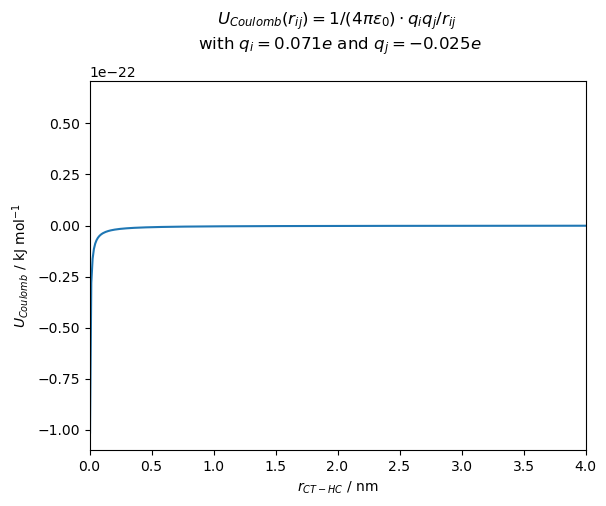

In [11]:
plot_U_Coulomb(dic,[1,6],printhere=True)